## Skipgrams in Keras

- In this lecture, we will implement Skipgrams in `Keras`.

#### Loading in and preprocessing data
- Load the Tanach Corpus
- `Keras` has some nice text preprocessing features tools.
- Split the text into sentences.
- Use `Keras`' `Tokenizer` to tokenize sentences into words.
- Use `Gensim` to preprocess the text

This is the Intel_week10 HW highly modified using
https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-skip-gram.html

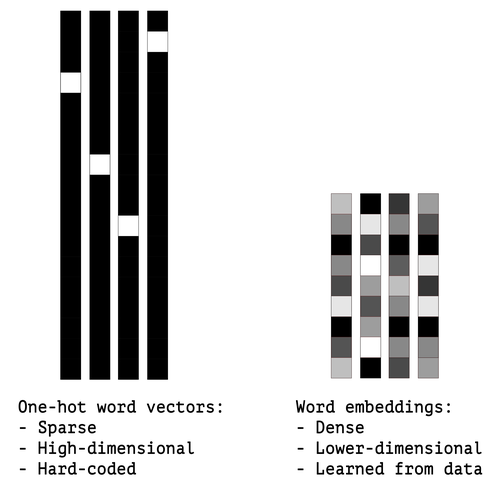

# Skipgram architecture - Softmax

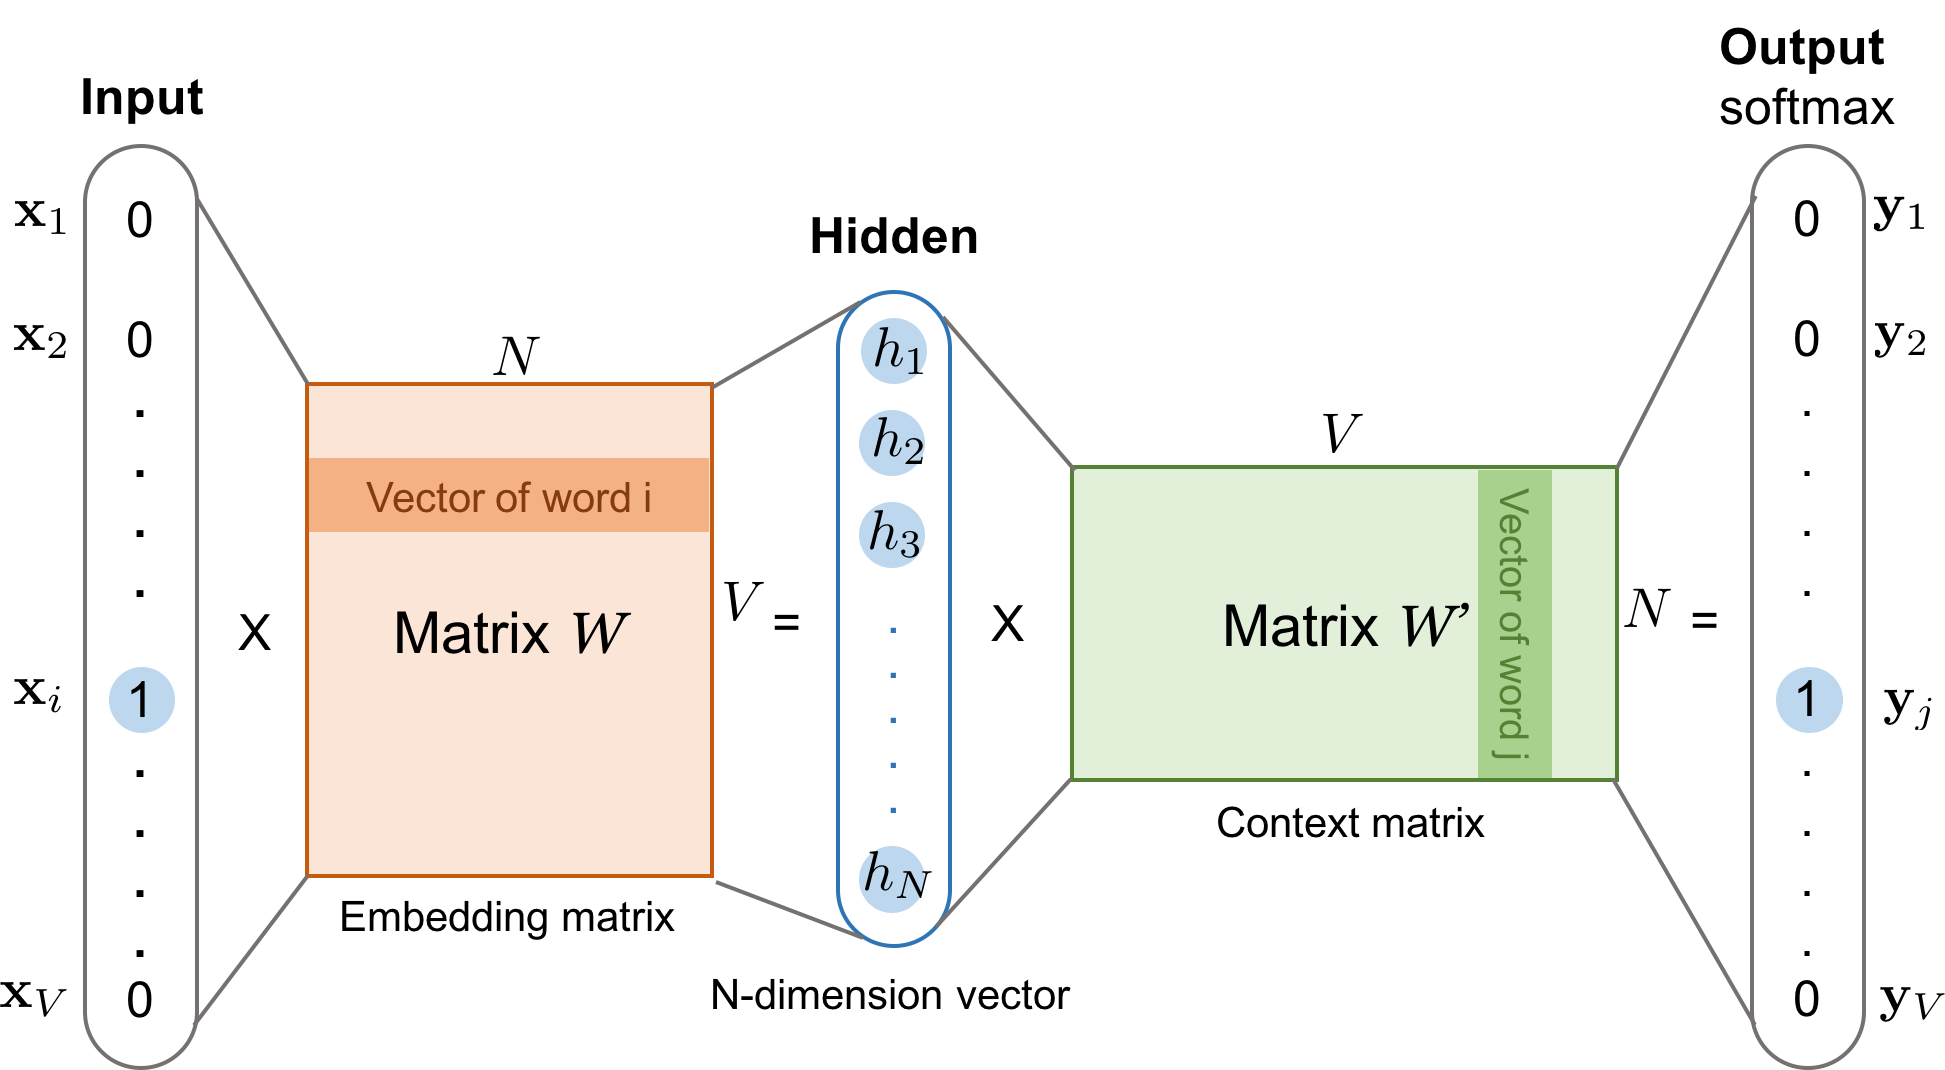

# Alternative skipgram architecture - Two-tower (or dual encoder)

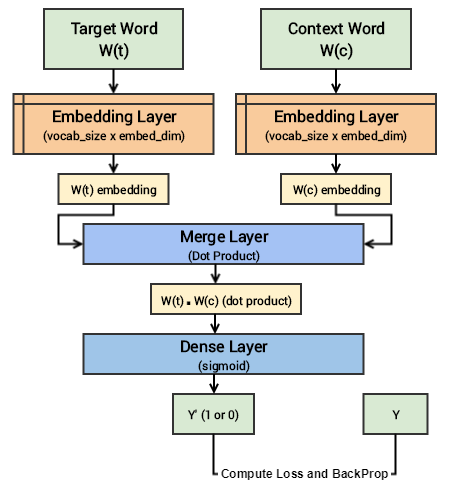

In [1]:
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
import numpy as np
import pandas as pd
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, strip_multiple_whitespaces

2023-05-07 21:14:39.210320: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-07 21:14:39.265531: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-07 21:14:39.574952: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-07 21:14:39.577254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 21:14:42.006107: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#### Load and preprocess the text

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path = 'Tanach.txt'
#downloadded from https://www.jewishvirtuallibrary.org/
corpus = open(path).readlines()

corpus = [strip_multiple_whitespaces(remove_stopwords(strip_punctuation(strip_numeric(sentence.lower())))) for sentence in corpus if sentence.count(' ') >= 2]

In [4]:
corpus[:10]

['beginning god created heaven earth',
 'earth form void darkness face deep spirit god moved face waters',
 'god said let light light',
 'god saw light good god divided light darkness',
 'god called light day darkness called night evening morning day',
 'god said let firmament midst waters let divide waters waters',
 'god firmament divided waters firmament waters firmament',
 'god called firmament heaven evening morning second day',
 'god said let waters heaven gathered unto place let dry land appear',
 'god called dry land earth gathering waters called seas god saw good']

In [5]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(corpus)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in corpus]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 4461
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('thee', 6), ('shalt', 7), ('said', 8), ('ye', 9), ('god', 10)]




```
# This is formatted as code
```

#### Skipgrams: Generating Input and Output Labels
- Now that we have sentences, and word tokenization, we are in good position to create our training set for skipgrams.
- Now we need to generate our `X_train` and `y_train`

From the Tensorflow Documentation:

"skipgram() function transforms a sequence of word indexes (list of integers) into tuples of words of the form:

(word, word in the same window), with label 1 (positive samples).
(word, random word from the vocabulary), with label 0 (negative samples)."

In [6]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=5) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(created (777), cakes (916)) -> 0
(beginning (975), dipped (2419)) -> 0
(created (777), heaven (119)) -> 1
(heaven (119), diverse (3741)) -> 0
(beginning (975), god (10)) -> 1
(heaven (119), hired (799)) -> 0
(heaven (119), increase (448)) -> 0
(earth (48), god (10)) -> 1
(beginning (975), hearth (3087)) -> 0
(god (10), heaven (119)) -> 1


### Skipgrams: Creating the Model (we will use the Functional API from Keras)
- Lastly, we create the (shallow) network!

In [7]:
dim_embedddings = 64

# inputs
w_inputs = Input(shape=(1, ), dtype='int32') #input is one word (ID)
w = Embedding(vocab_size, dim_embedddings)(w_inputs)


# context
c_inputs = Input(shape=(1, ), dtype='int32')
c = Embedding(vocab_size, dim_embedddings)(c_inputs)

o = dot([w, c], axes=(2, 2)) #dot product of word and context. Axes 2,2 because we want to dot product the last axis of each input.

o = Reshape((1,), input_shape=(1, 1))(o)
o = Activation('sigmoid')(o)

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
SkipGram.compile(loss='binary_crossentropy', optimizer='adam')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 64)        285504      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 64)        285504      ['input_2[0][0]']                
                                                                                              

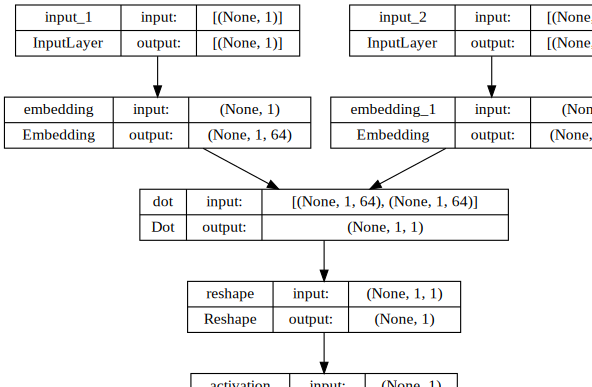

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(SkipGram, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

### Skipgrams: Compiling and Training
- Time to compile and train
- We use crossentropy, common loss for classification

In [84]:
# for epoch in range(1, 10):
#     loss = 0
dataset = []
for i, elem in enumerate(skip_grams):
    pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [pair_first_elem, pair_second_elem]
    Y = labels
    dataset.append([X, Y])
train, labels = zip(*dataset)
train = np.hstack(train)
labels = np.hstack(labels)
print(train.shape)

(2, 1081908)


In [89]:
SkipGram.fit([train[0], train[1]], labels, batch_size=512, epochs=5)

Epoch 1/5
2114/2114 [==============================] - 16s 8ms/step - loss: 0.4377
Epoch 2/5
2114/2114 [==============================] - 15s 7ms/step - loss: 0.3494
Epoch 3/5
2114/2114 [==============================] - 16s 8ms/step - loss: 0.3200
Epoch 4/5
2114/2114 [==============================] - 16s 7ms/step - loss: 0.2955
Epoch 5/5
2114/2114 [==============================] - 16s 7ms/step - loss: 0.2727


### Skipgrams: Looking at the vectors

To get word_vectors now, we look at the weights of the first layer.

Let's also write functions giving us similarity of two words.

In [102]:
weights = SkipGram.get_weights()[0]
vocab = id2word.values()

pd.DataFrame(weights, index=vocab).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
shall,0.030942,-0.028096,0.006037,-0.045560,0.017345,0.011668,0.017578,0.014402,-0.035447,-0.019795,...,-0.049292,0.005716,0.033560,-0.007125,0.001160,-0.004799,-0.001996,0.045833,-0.003478,-0.005239
unto,0.094167,0.378349,0.578663,0.096152,0.926392,0.063932,0.660993,-0.237721,0.123013,0.457775,...,0.805739,-0.101668,0.300965,0.432122,0.113445,0.833711,-0.431909,0.385017,0.031721,-0.388116
lord,0.455599,0.260453,-0.069253,0.544875,0.402942,0.249286,0.386636,0.385807,-0.376400,0.674615,...,0.588262,0.190432,0.128182,-0.058977,0.114993,0.440623,-0.666963,-0.090094,-0.074506,-0.404569
thou,0.148082,0.659760,-0.190262,-0.954883,0.254886,-0.088931,0.530391,0.107875,-0.207484,0.217302,...,0.390354,-0.023935,0.975579,-0.011272,-0.032579,-0.658484,-0.364878,-0.543133,0.163029,-0.006794
thy,-0.040569,0.525244,0.912422,-0.427714,0.485935,0.177815,0.512569,0.340984,-0.288315,0.136870,...,-0.963207,0.425032,0.586528,0.029208,0.764532,1.056309,-0.412693,-0.784951,1.007749,0.151947


In [103]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['tabernacle', 'noah', 'abraham', 'adam', 'joseph', 'moses', 'flour','bread']}

similar_words

(4461, 4461)


{'tabernacle': ['went', 'law', 'hoof', 'eleazar', 'overlaying'],
 'noah': ['lower', 'darkish', 'canaanites', 'stoodest', 'frost'],
 'abraham': ['pillar', 'goshen', 'elders', 'doings', 'booths'],
 'adam': ['expressed', 'repented', 'miracles', 'nobah', 'medad'],
 'joseph': ['sprung', 'canst', 'bank', 'complete', 'interpret'],
 'moses': ['nations', 'leprous', 'seventh', 'henceforth', 'asses'],
 'flour': ['scall', 'occupied', 'reared', 'grate', 'desolate'],
 'bread': ['woman', 'feasts', 'gad', 'horsemen', 'desolate']}


##Visualizing the embeddings
###save embedings to drive and visualize using

###[Embedding projector](https://projector.tensorflow.org)

In [104]:
#save embeddings and then upload to projector

import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

# #download to disk (and then upload to drive: '/content/drive/MyDrive/Machon Lev/DL_5783/Materials/Models/')

# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

###Notes:

*   You can use "Gensim" to generate word embeddings for our corpus in Python

*   More on Word2vec [here](https://jalammar.github.io/illustrated-word2vec/)



## Your turn:


1.   Play with the window_size length. Which similar words you get?
2.   Modify the code above to create a [CBOW Model](https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html) 



In [9]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(corpus)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in corpus]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 4461
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('thee', 6), ('shalt', 7), ('said', 8), ('ye', 9), ('god', 10)]


In [9]:
import tensorflow as tf
from keras.utils import pad_sequences

window_size = 2
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    train = []
    labels = []
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            train.append(x[0])
            labels.append(y[0])
    return train, labels
            
            
# Test this out for some samples
# i = 0
# for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
#     if 0 not in x[0]:
#         print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
#         if i == 10:
#             break
#         i += 1
train, labels = generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size)

In [18]:
#CBOW model
import keras.backend as K
from keras.layers import Dense, Embedding, Lambda, GlobalAveragePooling1D
dim_embeddings=32
inputs = Input(shape=(window_size*2, ), dtype='int32')

embedding = Embedding(input_dim=vocab_size, output_dim=dim_embeddings, input_length=window_size*2, name='embedding')(inputs)
mean = GlobalAveragePooling1D()(embedding)
dense = Dense(units=vocab_size, activation='softmax', name='softmax')(mean)



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 embedding (Embedding)       (None, 4, 32)             142752    
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 softmax (Dense)             (None, 4461)              147213    
                                                                 
Total params: 289,965
Trainable params: 289,965
Non-trainable params: 0
_________________________________________________________________


In [39]:
CBOW = Model(inputs=inputs, outputs=dense)
CBOW.summary()
CBOW.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
CBOW.fit(x=np.array(train), y=np.array(labels), batch_size=64, epochs=5, validation_split=0.1)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 embedding (Embedding)       (None, 4, 32)             142752    
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 softmax (Dense)             (None, 4461)              147213    
                                                                 
Total params: 289,965
Trainable params: 289,965
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
948/948 [==============================] - 14s 13ms/step - loss: 5.0787 - accuracy: 0.1770 - val_loss: 5.6777

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
weights = CBOW.get_weights()[0]
vocab = id2word.values()

pd.DataFrame(weights, index=vocab).head()
distance_matrix = cosine_similarity(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                     for search_term in ['tabernacle', 'noah', 'abraham', 'adam', 'joseph', 'moses', 'flour','bread']}
similar_words

(4461, 4461)


{'tabernacle': ['blessed', 'soul', 'canaan', 'hath', 'silver'],
 'noah': ['wash', 'head', 'goeth', 'sarai', 'sun'],
 'abraham': ['shall', 'hand', 'minister', 'know', 'esau'],
 'adam': ['diligently', 'true', 'beasts', 'encamp', 'sale'],
 'joseph': ['number', 'judgment', 'shall', 'nakedness', 'shekels'],
 'moses': ['soul', 'bring', 'gold', 'flesh', 'called'],
 'flour': ['stranger', 'greater', 'observe', 'office', 'word'],
 'bread': ['word', 'gone', 'savour', 'flour', 'sun']}

Lets see if we can get better accuracy:

In [21]:
import tensorflow as tf
from keras.utils import pad_sequences

window_size = 5
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    train = []
    labels = []
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            train.append(x[0])
            labels.append(y[0])
    return train, labels
            
            
# Test this out for some samples
# i = 0
# for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
#     if 0 not in x[0]:
#         print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
#         if i == 10:
#             break
#         i += 1
train, labels = generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size)

In [22]:
from keras.optimizers import Adam
#CBOW model
import keras.backend as K
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
dim_embeddings=64
inputs = Input(shape=(window_size*2,), dtype='int32')
#two layers this time
embedding = Embedding(input_dim=vocab_size, output_dim=dim_embeddings, input_length=window_size*2, name='embedding')(inputs)
mean = GlobalAveragePooling1D()(embedding)
dense = Dense(units=vocab_size, activation='softmax', name='softmax')(mean)
CBOW = Model(inputs=inputs, outputs=dense)
CBOW.summary()

CBOW.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',  metrics=['accuracy'])
CBOW.fit(x=np.array(train), y=np.array(labels), batch_size=64, epochs=15, validation_split=0.1)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 64)            285504    
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 softmax (Dense)             (None, 4461)              289965    
                                                                 
Total params: 575,469
Trainable params: 575,469
Non-trainable params: 0
_________________________________________________________________


/home/shua/miniconda3/envs/lev_ml/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
948/948 [==============================] - 12s 12ms/step - loss: 6.8445 - accuracy: 0.0405 - val_loss: 6.5413 - val_accuracy: 0.0488
Epoch 2/15
948/948 [==============================] - 11s 11ms/step - loss: 6.4412 - accuracy: 0.0505 - val_loss: 6.5025 - val_accuracy: 0.0585
Epoch 3/15
948/948 [==============================] - 11s 11ms/step - loss: 6.2382 - accuracy: 0.0647 - val_loss: 6.3899 - val_accuracy: 0.0752
Epoch 4/15
948/948 [==============================] - 11s 11ms/step - loss: 5.9691 - accuracy: 0.0734 - val_loss: 6.2887 - val_accuracy: 0.0804
Epoch 5/15
948/948 [==============================] - 10s 11ms/step - loss: 5.7333 - accuracy: 0.0811 - val_loss: 6.2218 - val_accuracy: 0.0902
Epoch 6/15
948/948 [==============================] - 7s 8ms/step - loss: 5.5374 - accuracy: 0.0917 - val_loss: 6.1692 - val_accuracy: 0.0996
Epoch 7/15
948/948 [==============================] - 10s 11ms/step - loss: 5.3671 - accuracy: 0.1025 - val_loss: 6.1266 - val_accuracy: 0

In [24]:
# from sklearn.metrics.pairwise import euclidean_distances
# weights = CBOW.get_weights()[0]
# vocab = id2word.values()

# pd.DataFrame(weights, index=vocab).head()
# distance_matrix = euclidean_distances(weights)
# print(distance_matrix.shape)

# similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
#                    for search_term in ['tabernacle', 'noah', 'abraham', 'adam', 'joseph', 'moses', 'flour','bread']}

# similar_words

#Do the same but for cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
weights = CBOW.get_weights()[0]
vocab = id2word.values()

pd.DataFrame(weights, index=vocab).head()
distance_matrix = cosine_similarity(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                     for search_term in ['tabernacle', 'noah', 'abraham', 'adam', 'joseph', 'moses', 'flour','bread']}
similar_words


(4461, 4461)


{'tabernacle': ['mastery', 'dignity', 'razor', 'huz', 'drunken'],
 'noah': ['sacrificeth', 'job', 'ithamar', 'ziphion', 'united'],
 'abraham': ['ouches', 'abode', 'virgin', 'ammiel', 'blot'],
 'adam': ['razor', 'gird', 'fly', 'leaves', 'vain'],
 'joseph': ['nuts', 'longeth', 'seventy', 'taller', 'chemosh'],
 'moses': ['daubed', 'streams', 'eleloheisrael', 'provide', 'child'],
 'flour': ['believed', 'descending', 'prevail', 'ascending', 'fourscore'],
 'bread': ['altars', 'ready', 'jabbok', 'hornet', 'king']}